# Gradient-based Visualization of CNN Representations

## (I) Introduction

While neural networks have shown impressive performance — with the notable example of computer vision tasks — their interpretability remains a concerning challenge. One of the most successful methods for understanding how neural networks build their "understanding" of a dataset is by _visualizing learned features using optimization_.

Generally, neural networks are differentiable with respect to their inputs [1]. Therefore, if we are interested in finding out what kind of input pattern(s) activate certain neurons, we can optimize the input to do so! This way, we can visualize the patterns that different layers of a trained model would find "interesting".





### This project

In this project, you will implement basic ideas of CNN feature visualization, using a pre-trained CNN architecture — VGG19.

We start off by loading and trimming the VGG model. Next, we build an optimization pipeline step by step in JAX. Building upon this, we will create a simple, but versatile, visualization class for VGG19 enabling us to easily perform experiments and plot visualizations of different layers, channels, and neurons in the model of interest.


### References
[1] [Olah, et al., "Feature Visualization", Distill, 2017.](https://distill.pub/2017/feature-visualization/)  
[2] [TensorFlow DeepDream Tutorial](https://www.tensorflow.org/tutorials/generative/deepdream)

---

## (II) Setting Up Local Dependencies

We use google drive to import local dependencies into the colab session. 📢 Running the following cell will create a folder named `ECE421_FeatureVis` in the root directory of your google drive, and downloads the needed files. Make sure to have at least 600 MBs of available space in the Gdrive you select. (You can always create a new account!)

You can access a file browser for this colab session, by clicking the _folder_ icon from the left panel. The current directory, where this notebook is located, is at `/content`. (You can print the present working directory by running `!pwd`.)

 Once the cell finished running, you should be able to see `utils.py` and `objax/zoo/pretrained/vgg19.npy` added to the current directory. 

In [ ]:
from pathlib import Path
gdrive_path = Path('./drive')
gdrive_asn_dir = 'ECE421_FeatureVis'

# mount your google drive to colab session
import os
from google.colab import drive
drive.mount(gdrive_path.as_posix())
gdrive_path  /= 'My Drive'

# create a directory in gdrive to download local dependencies
os.makedirs(gdrive_path/gdrive_asn_dir, exist_ok=True)

# download local dependencies
import gdown
vgg_path = gdrive_path / gdrive_asn_dir / 'vgg19.npy'
utils_path = Path('./utils.py')
if not vgg_path.exists():
    vgg19_gdrive_id = '1eAiFwI4fYsl3nRyLAOLBgu0YEvQ45exh'
    url = f'https://drive.google.com/uc?id={vgg19_gdrive_id}'
    gdown.download(url, vgg_path.as_posix(), quiet=False)
if not utils_path.exists():
    utils_url = 'https://github.com/mamaj/cnn-featurevis-ece421/raw/master/utils.py'
    gdown.download(utils_url, utils_path.as_posix(), quiet=False)

# copy dependencies from gdrive into the colab session
from shutil import copyfile
os.makedirs('./objax/zoo/pretrained', exist_ok=True)
copyfile(vgg_path, "./objax/zoo/pretrained/vgg19.npy")

# unmount gdrive
drive.flush_and_unmount()

Mounted at drive


Downloading...
From: https://github.com/mamaj/cnn-featurevis-ece421/raw/master/utils.py
To: /content/utils.py
1.60kB [00:00, 1.38MB/s]                 


In [ ]:
!pip install --quiet --upgrade objax

# This makes JAX allocate exactly what is needed on demand, and deallocate 
# memory that is no longer needed. More info:
# https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform' 

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import objax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from utils import imshow, interct_imshow
import utils

# (1) The CNN Model: VGG19

[VGG19 architecture](https://arxiv.org/abs/1409.1556) consists of 16 consecutive 3$\times$3 convolution layers with max poolings in between, followed by 3 fully connected layers. We are interested in examining input patterns that excite the neurons in different convolutional layers. 

<figure>
<img src="https://raw.githubusercontent.com/mamaj/cnn-featurevis-ece421/master/figs/vgg19_2.png"
     alt="VGG19 architecture"
     style="float: left; margin-right: 5px;"
     height="300px" />
<figcaption>VGG19 architecture</figcaption>

</figure>

We can import a VGG19 model, pretrained on [ImageNet dataset](http://www.image-net.org/), using Objax. [`objax.zoo` package](https://objax.readthedocs.io/en/latest/objax/zoo.html) contains implementations for a handful of famous networks. 


The following cell loads a pretrained `VGG19` object as a subclass of [`objax.nn.Sequential`](https://objax.readthedocs.io/en/latest/objax/nn.html#objax.nn.Sequential) class. An objax `Sequential` object can be thought of as a `list` of different [modules](https://objax.readthedocs.io/en/latest/advanced/variables_and_modules.html#module) (e.g. convolution layers, ReLU activations, poolings, etc.), where each module can be accessed like regular `list` elements. In addition, calling a `Sequential` object with any input executes its modules in order.

In [ ]:
from objax.zoo import vgg
model = vgg.VGG19(pretrained=True)

Objax VGG19 model accepts inputs as a batch of images in _Channels-First_ format: `(batch, channel, height, width)`, with pixel values in the range of [0 ... 255]. Note that matplotlib and `IPython.Display` modules accept images in _Channels-Last_ format: `(height, width, channel)`.
You may use `imshow()` and `interact_imshow()` helper functions from `utils.py` for plotting images, which also take care of the channel ordering conversions. 

`utils.get_vgg19_layer_names` returns a list of the names of every layer in VGG19. Let us print the index, name, and input/output depth/size of each layer in this model.

In [ ]:
layer_names = utils.get_vgg19_layer_names(model)

# print index, name, input -> output depth/size for each NN layer in `model`.
for i, name in enumerate(layer_names):
    if isinstance(model[i], (objax.nn.Conv2D, objax.nn.Linear)):
        in_shape, out_shape = model[i].w.value.shape[-2:]
        print(f'{i} \t {name}    \t {in_shape} \t -> \t {out_shape}')
    else:
        print(f'{i} \t {name}')

0 	 conv1_1    	 3 	 -> 	 64
1 	 relu1_1
2 	 conv1_2    	 64 	 -> 	 64
3 	 relu1_2
4 	 pool1
5 	 conv2_1    	 64 	 -> 	 128
6 	 relu2_1
7 	 conv2_2    	 128 	 -> 	 128
8 	 relu2_2
9 	 pool2
10 	 conv3_1    	 128 	 -> 	 256
11 	 relu3_1
12 	 conv3_2    	 256 	 -> 	 256
13 	 relu3_2
14 	 conv3_3    	 256 	 -> 	 256
15 	 relu3_3
16 	 conv3_4    	 256 	 -> 	 256
17 	 relu3_4
18 	 pool3
19 	 conv4_1    	 256 	 -> 	 512
20 	 relu4_1
21 	 conv4_2    	 512 	 -> 	 512
22 	 relu4_2
23 	 conv4_3    	 512 	 -> 	 512
24 	 relu4_3
25 	 conv4_4    	 512 	 -> 	 512
26 	 relu4_4
27 	 pool4
28 	 conv5_1    	 512 	 -> 	 512
29 	 relu5_1
30 	 conv5_2    	 512 	 -> 	 512
31 	 relu5_2
32 	 conv5_3    	 512 	 -> 	 512
33 	 relu5_3
34 	 conv5_4    	 512 	 -> 	 512
35 	 relu5_4
36 	 pool5
37 	 flatten
38 	 fc6    	 25088 	 -> 	 4096
39 	 relu6
40 	 fc7    	 4096 	 -> 	 4096
41 	 relu7
42 	 fc8    	 4096 	 -> 	 1000


Since we are only interested in convolutional layers, we need to first chop off the last three fully connected layers. This will also let us input images with arbitrary sizes to the model:

> By design, the inputs to the VGG model should be images of size 224$\times$224 pixels. This limit is imposed by fixed sizes of the last fully connected layers.  Without them, images with arbitrary sizes can be processed in the convolutional layers, since the output of each layer will scale according to the input size.


In [ ]:
flatten_idx = None 

# TODO: 
# Find the index of the "flatten" layer in model, assign it to `flatten_idx` and
# instantiate a new objax.nn.Sequential model using only the layers before the 
# flatten.

# The index of "flatten0" is 37
flatten_idx = 37

layer_names = layer_names[:flatten_idx]
print(layer_names)

model_2 = vgg.VGG19(pretrained=True)
while len(model_2) > 37:
    model_2.pop(-1)


# print index, name, input -> output depth/size for each NN layer in `model`.
for i, name in enumerate(layer_names):
    if isinstance(model_2[i], (objax.nn.Conv2D, objax.nn.Linear)):
        in_shape, out_shape = model_2[i].w.value.shape[-2:]
        print(f'{i} \t {name}    \t {in_shape} \t -> \t {out_shape}')
    else:
        print(f'{i} \t {name}')

['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5']
0 	 conv1_1    	 3 	 -> 	 64
1 	 relu1_1
2 	 conv1_2    	 64 	 -> 	 64
3 	 relu1_2
4 	 pool1
5 	 conv2_1    	 64 	 -> 	 128
6 	 relu2_1
7 	 conv2_2    	 128 	 -> 	 128
8 	 relu2_2
9 	 pool2
10 	 conv3_1    	 128 	 -> 	 256
11 	 relu3_1
12 	 conv3_2    	 256 	 -> 	 256
13 	 relu3_2
14 	 conv3_3    	 256 	 -> 	 256
15 	 relu3_3
16 	 conv3_4    	 256 	 -> 	 256
17 	 relu3_4
18 	 pool3
19 	 conv4_1    	 256 	 -> 	 512
20 	 relu4_1
21 	 conv4_2    	 512 	 -> 	 512
22 	 relu4_2
23 	 conv4_3    	 512 	 -> 	 512
24 	 relu4_3
25 	 conv4_4    	 512 	 -> 	 512
26 	 relu4_4
27 	 pool4
28 	 conv5_1    	 512 

# (2) Hands-on
In this section, we perform *gradient ascent* on an input image to *maximize* the mean activation of the last layer neurons.

> Similar to the idea of gradient descent—where in order to minimize an objective function, we take steps proportional to the negative of its gradient at the current point—with gradient *ascent*, we iteratively maximize the value of an objective function by taking steps *towards* the direction of its gradient, at each point.

Implement the loss function below to return the mean activation of the last layer of its `model` argument given an input image `x`.

In [ ]:
def loss(model, x):
    # Edited by Jason, Nov. 20, 2020
    # Edited by Jason, Nov. 28, 2020

    for i in range(flatten_idx):
    x = model[i](x)
    # z = model(x)
    y = x.mean()

    return y

Update image `x` by applying **one** step of gradient ascent.

Notes:
* Use JAX's `grad` method to find the gradient of the loss w.r.t the input image.
* Clip the updated image to have values in the range [0...255]. You may find `jnp.clip()` very helpful.
* To have easier step size tuning, normalize the gradient values to have unit variance.

In [ ]:
@jit
def update_input(x, step_size=1.):
    # Edited by Jason, Nov. 21, 2020
    x = x.astype(jnp.float32)
    g = grad(loss, argnums=1)(model_2, x)
    g_ = (g-0)/g.std()
    x = x + g_ * step_size
    x = jnp.clip(x, 0, 255).astype(jnp.float32)

    return x

Perform `steps` iterations of gradient ascent using `update_input()` method you implemented above. Keep track of each updated input and return them in a list as an output.  

Use `trange` instead of `range` in your for-loop to plot a progress bar of your loop executions. (This is, truly, maximal utility by minimal intervention) 

In [ ]:
def visualize(x, steps=150, step_size=1.):
    img_list = [x]

    for i in trange(0,steps,int(step_size)):
    x = update_input(x)
    img_list.append(x)

    return x, img_list

Generate a random input image, such that every pixel's red, green, or blue element is turned on (=255) with probability 0.001, and is turned off (=0) with probability 0.999, independently. Do not forget to include the leading batch dimension.

A sample image should look almost black with sporadic red, green, and blue pixels. You may use random modules from either JAX or NumPy. You can also use `imshow()` from `utils.py` to plot a single image in this project. 

The shape of the image is: (3, 400, 400)


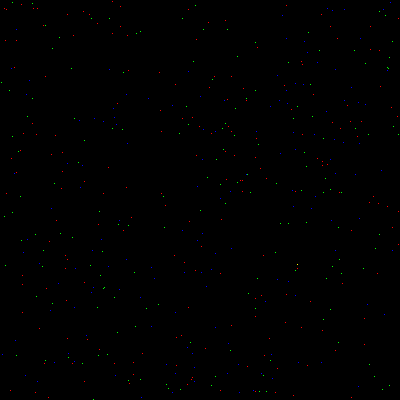

In [ ]:
def random_image(key, size=(300, 300), p=0.001):

    # Edited by Jason, Nov. 21, 2020

    # x = np.zeros([3, size[0], size[1]], dtype=int)
    # print('The shape of the image is:', np.shape(x))
    # for h in range(size[0]):
    #   for w in range(size[1]):
    #     r = np.random.randint(0,1000)
    #     R = 255 if r<=0 else 0
    #     g = np.random.randint(0,1000)
    #     G = 255 if g<=0 else 0
    #     b = np.random.randint(0,1000)
    #     B = 255 if b<=0 else 0
    #     x[:,h,w] = R,G,B

    x = np.random.choice(np.array([255, 0]), p=[p, 1-p], size = (1, 3, size[0], size[1])).astype('float')

    return x

key = jax.random.PRNGKey(0)
x = random_image(key, size=(400, 400), p=0.001)
print('The shape of the image is:', np.shape(x[0]))
imshow(x[0])

We can use `interct_imshow()` to explore the evolution of the input image throughout the optimization. 

In [ ]:
x_hat, img_list = visualize(x, steps=300, step_size=1.)
interct_imshow(img_list)

interactive(children=(IntSlider(value=300, description='idx', max=300), Output()), _dom_classes=('widget-inter…

### Taking it up an octave <sup><sub>[from [2]](https://www.tensorflow.org/tutorials/generative/deepdream#taking_it_up_an_octave)</sub></sup>

Pretty good, but there are a few issues with this first attempt:

* The output is noisy.
* The image is low resolution.
* The patterns appear like they're all happening at the same granularity.

One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an _octave_), and repeat this process for multiple octaves.




Implement `visualize_octave()` as follows:

For each octave `n` in `oct_range`, you need to:
* First, resize the optimized image of the previous step to  `base_shape * (oct_scale ** n)`, where  `base_shape` is the shape of the original input image.
* Then, apply another round of optimization updates using the `visualize()` method.


Notes:
* Keep track of each updated input and return them in a list as an output.  
* You may also use [`jax.image.resize()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.image.resize.html) for scaling the input image. 

In [ ]:
def visualize_octave(x, oct_range=range(-2, 3), oct_scale=1.8, steps_per_oct=100, step_size=1.):
    img_list = []
    base_shape = np.shape(x)
    print('The base_shape is:', base_shape)
    for n in oct_range:
        print("octave iteration", n+3)
        height = np.ceil(base_shape[2]*(oct_scale**n))
        width = np.ceil(base_shape[3]*(oct_scale**n))
        print("height and width are:", height, width)
        new_shape = (base_shape[0], base_shape[1], height, width)
        x = jax.image.resize(x, new_shape, "bilinear", antialias=False)
        x, img_list_temp = visualize(x, steps=steps_per_oct, step_size=step_size)
        img_list.extend(img_list_temp)
  
    x_hat = x

    return x_hat, img_list

Now, run the optimization using the octave scaling trick and plot the result. Much better!

In [ ]:
x = random_image(key, size=(200, 200), p=0.001)
x_hat, img_list = visualize_octave(x)
interct_imshow(img_list)

# delete to release memory
import gc
del model
del img_list
del x_hat
del x
del loss
del update_input
del visualize
del visualize_octave
gc.collect()

The base_shape is: (1, 3, 200, 200)
octave iteration 1
height and width are: 62.0 62.0


/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



octave iteration 2
height and width are: 112.0 112.0



octave iteration 3
height and width are: 200.0 200.0



octave iteration 4
height and width are: 360.0 360.0



octave iteration 5
height and width are: 648.0 648.0


interactive(children=(IntSlider(value=504, description='idx', max=504), Output()), _dom_classes=('widget-inter…

265

# (3) Visualizer Class

In this section, we package all the methods we implemented so far into a class. In addition, we are going to add another functionality: selecting wich layers, which channels in a layer, or which neurons of a channel to maximize:

<figure>
  <img src="https://raw.githubusercontent.com/mamaj/cnn-featurevis-ece421/master/figs/opt_objective.png"
      alt="Different optimization objectives"
      style="float: left; margin-right: 5px;"
      height="300px"/>
  <figcaption>Different optimization objectives show what different parts of a network are looking for. Taken from [1].</figcaption>
</figure>

In order to do so, we need to take control of the forward pass calculation of the model, and keep references of intermediate activations of interest (neurons, channels, or layers). We can also use the mean activation of _multiple_ layers as objective.


Use the methods implemented above to complete the definition of the class below.

Note that we use the new `forward_path` method in the `loss` function.

In [ ]:
class FeatureVis(objax.Module):
  
    def __init__(self, base_model, layers, channels=None, neurons=None):
        '''
        layers : list of ints
          the index of layers to select from base_model.

        channels: None or a list of ints with the same length as `layers`.
          if None, selects all channels, otherwise, select channels[i] for layers[i]. 

        neurons: None or a list of 2d tuples with the same length as `layers`.
          if None, selects all neurons, otherwise, select neurons[i] for layers[i].
        '''
        if isinstance(layers, int):
            layers = [layers]
        if channels is None:
            channels = [slice(None)] * len(layers)
        if neurons is None:
            neurons = [(slice(None), slice(None))] * len(layers)

        self.layers = layers
        self.channels = channels
        self.neurons = neurons
        self.model = base_model
        super().__init__()
  
    def forward_pass(self, x):
        activations = []
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in self.layers:
                c = self.channels[self.layers.index(i)]
                n = self.neurons[self.layers.index(i)]
                activations.append(x[:, c, n[0], n[1]])
            if len(activations) == len(self.layers):
                break
        return activations

    def loss(self, x):
        activations = self.forward_pass(x)
        return jnp.sum(jnp.array([a.mean() for a in activations]))

    @partial(jit, static_argnums=(0,))
    def update_input(self, x, step_size):
        x = x.astype(jnp.float32)
        g = grad(self.loss, argnums=0)(x)
        # g = (g-g.mean())/g.std()
        g = (g-0)/g.std()
        # x = x + g * step_size
        x = jnp.clip(x + g * step_size, 0, 255).astype(jnp.float32)
        return x

    def __call__(self, x, steps=150, step_size=1.):
        for i in trange(0, steps, int(step_size)):
            x = self.update_input(x, int(step_size))
        return x


    def vis_octave(self, x, oct_range=range(-2, 3), oct_scale=1.8, steps_per_oct=100, step_size=1.):
        base_shape = np.shape(x)
        # print('The base_shape is:', base_shape)
        for n in oct_range:
            # print("octave iteration", n+3)
            # height = np.ceil(base_shape[2]*(oct_scale**n))
            # width = np.ceil(base_shape[3]*(oct_scale**n))
            # print("height and width are:", height, width)
            # new_shape = (base_shape[0], base_shape[1], height, width)
            x = jax.image.resize(x, (base_shape[0], base_shape[1], np.ceil(base_shape[2]*(oct_scale**n)), np.ceil(base_shape[3]*(oct_scale**n))), "bilinear", antialias=False)
            x = self(x, steps=steps_per_oct, step_size=int(step_size))
        return x

Run the visualization using `FeatureVis` class for channel 1 of _all_ convolutional layers in VGG19.

Notes:   
* As you may have already noticed, Objax implementation of a neural network "layer" only contains weight matrix multiplication (or convolution operation), and activation functions are applied separately following the layers, whereas in the class we treated a layer as the weight matrix multiplication + activation.   
Therefore, when initializing `FeatureVis` objects, be careful to select `layers` corresponding to ReLU activation functions.

* You should keep the optimized image for each layer in `results` list, and the name of each layer in `names` list.
* To optimize for each layer, you need to instantiate a new `FeatureVis` object with a different layer as its constructor argument. Do _not_ manually change `FeatureVis.layers`.

In [ ]:
results = []
names = []

size = (100, 100)
steps_per_oct = 100
channel = 1

input_img = random_image(key, size=size, p=0.001)

results.append(input_img)
names.append('input')

# Run the visualization using `FeatureVis` class for channel 1 of 
# _all_ CNN layers in VGG19.

x = input_img
# gc.disable()
for la in range(len(layer_names)):
    if layer_names[la][0] == 'c':
        print('layer index for this iteration:', la, la+1)
        x = FeatureVis(model_2, [la, la+1], [channel, channel]).vis_octave(x, steps_per_oct=100, step_size=1)
        # obj = FeatureVis(model_2, [la, la+1], [channel, channel])
        # x = obj.vis_octave(x, steps_per_oct=100, step_size=1)
        # x = obj.__call__(x, steps=steps_per_oct)
        # y = jax.image.resize(x, [1,3,300,300], "bilinear", antialias=False)
        results.append(x)
        x = jax.image.resize(x, [1,3,size[0],size[1]], "bilinear", antialias=True)
        names.append(layer_names[la+1])
        # print(sys.getrefcount(obj))
        # del obj
        gc.collect()
        la += 1

from IPython import display
display.clear_output()

The following cell will plot the optimized images for each layer:

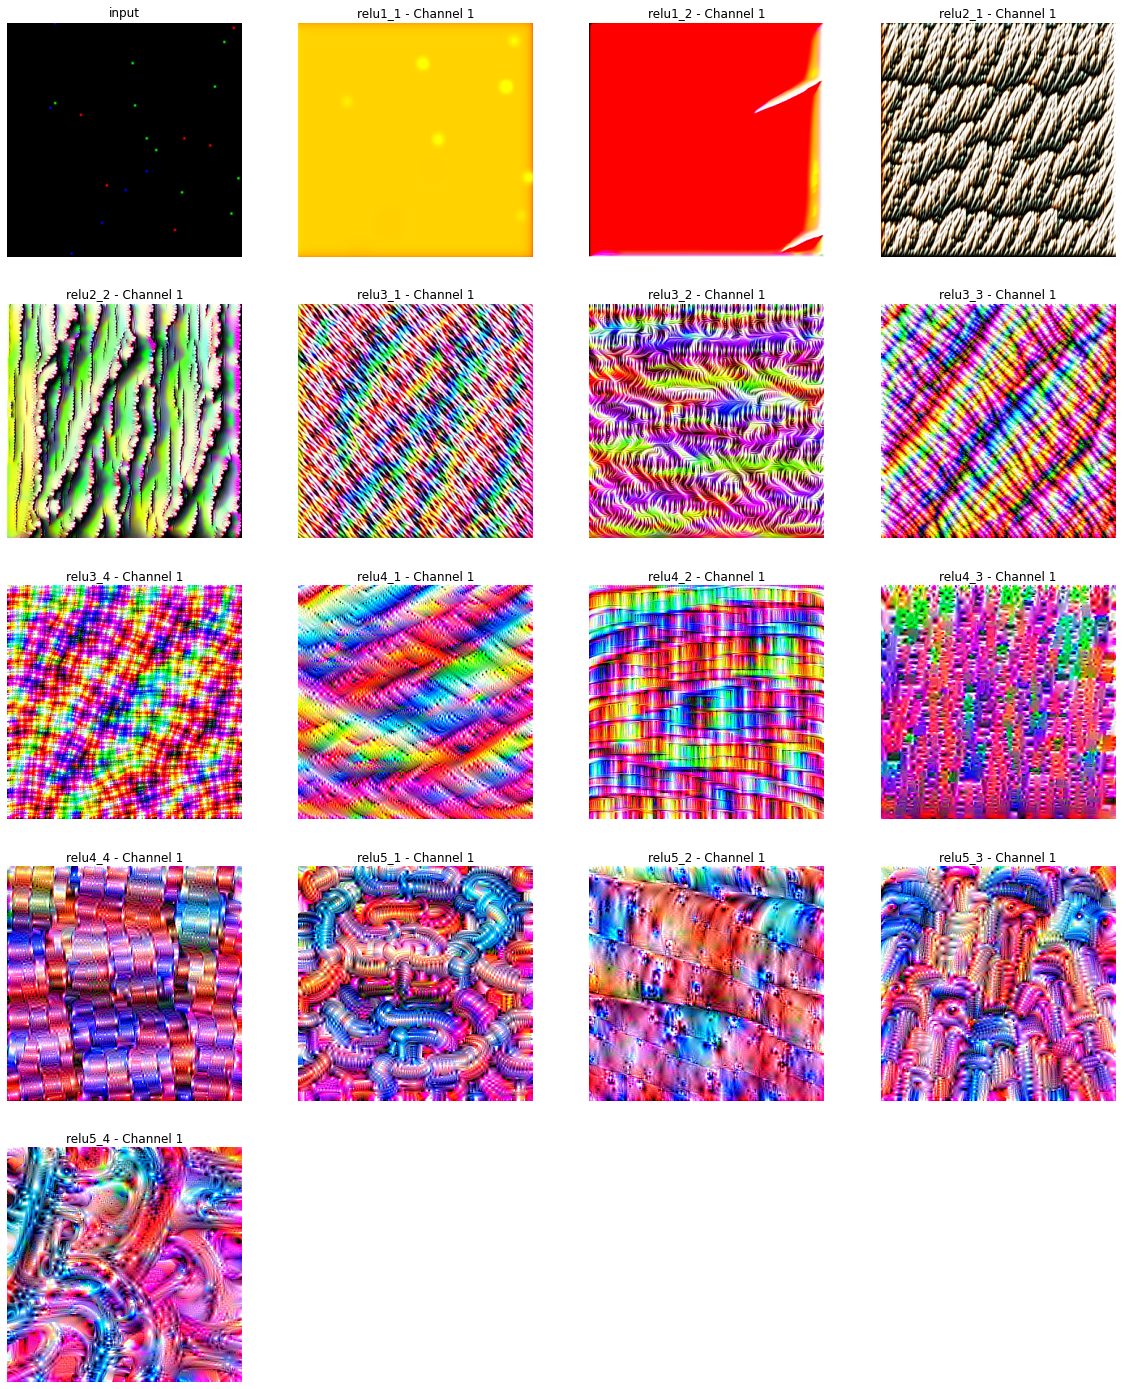

In [ ]:
from objax.util.image import nhwc
from math import ceil

n_cols = 4
n_rows = ceil(len(results) / n_cols)
ax_size = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(ax_size*n_cols, ax_size*n_rows))
for ax in axs.flat: ax.set_axis_off()
for name, ax, x in zip(names, axs.flat, results):
    ax.imshow(nhwc(x)[0].astype(np.uint8))
    ax.set_title(f'{name} - Channel {channel}')
axs[0, 0].set_title('input');

The visualizations obtained for the first-level convolutions are simple, dark scene with sporadic red, green, and blue pixels. As data goes deeper through layers, the visualization becomes more and more complicated, in terms of colors, features, patterns, and interaction of different patterns inside. Also, in shallower layers, the patterns look dense and blobby, while in deeper layers the patterns look localized and sparse. In addition, the patterns in deep layers look like interactions of patterns in the previous layer. The evolution is especially clear in the last few deep layers. Based on this observation, I think the shallower layers of a CNN tend to recognize direct, obvious, and global patterns on an image, while deeper layers tend to recognize indirect and localized patterns and interaction of patterns on the image.

## CNN Receptive Field


Perform the visualization procedure (without octave scaling) to maximize the activation of neurons in coordinate (5, 5) over all channels for a shallow layer (`relu2_2`) and a deep layer (`relu5_4`).

In [ ]:
# release memory
del x
del names
del results
del size
del steps_per_oct
del channel
del input_img
del n_cols
del n_rows
del ax_size
del fig
del axs
gc.collect()

x = random_image(key, size=(300, 300), p=0.001)

# Visualize features of neuron (5, 5) in layer `relu2_2`
layer = []
neuron = []
for la in range(9):
    if layer_names[la][0] == 'c':
        layer.extend([la, la+1])
        neuron.extend([(5,5), (5,5)])
        la += 1
y = FeatureVis(model_2, layer, channels=None, neurons=neuron)(x, steps=150, step_size=1.)
print('Visualize features of neuron (5, 5) in layer `relu2_2`')
interct_imshow(y)

# Visualize features of neuron (5, 5) in layer `relu5_4`
# release memory
del layer
del neuron
del y
gc.collect()

layer = []
neuron = []
for la in range(36):
    if layer_names[la][0] == 'c':
        layer.extend([la, la+1])
        neuron.extend([(5,5), (5,5)])
        la += 1
y = FeatureVis(model_2, layer, channels=None, neurons=neuron)(x, steps=150, step_size=1.)
print('Visualize features of neuron (5, 5) in layer `relu5_4`')
interct_imshow(y)

del layer
del neuron
del y
del x
gc.collect()


Visualize features of neuron (5, 5) in layer `relu2_2`


interactive(children=(IntSlider(value=0, description='idx', max=0), Output()), _dom_classes=('widget-interact'…


Visualize features of neuron (5, 5) in layer `relu5_4`


interactive(children=(IntSlider(value=0, description='idx', max=0), Output()), _dom_classes=('widget-interact'…

19

In a convolution layer, each neuron looks at a small region of an image, and weights are shared between all regions. In our case, the colored pixels are sporadically located at the black scene. It is likely that in a large region, there is only one colored pixel. However, as convolution window slides across the large region, it deals with several small regions. These small regions are overlapping, and each of them can lead to a colored pixel in the output. As a result, the output of the data through the convolution layer would have more than one colored pixels. Though activation can disable some pixels, there would likely be more colored pixels than before. That's why we see a wider area affected by the deeper neurons.

# (4) The Art: Deep Dream


Besides bringing insights into how CNNs build up their "understanding" of images from the dataset they are trained on, as you might have wondered, the generated images are stunning! 

We can apply this dream-like effect to an image by using it as the starting point of the optimization. As you may already know, this is called "deep dream". If you are interested, watch this amazing [video](https://youtu.be/SCE-QeDfXtA), and see [here](https://deepdreamgenerator.com/) for an online deep dream tool.

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


layer index for this iteration: 0 1



layer index for this iteration: 2 3



layer index for this iteration: 5 6



layer index for this iteration: 7 8



layer index for this iteration: 10 11



layer index for this iteration: 12 13



layer index for this iteration: 14 15



layer index for this iteration: 16 17



layer index for this iteration: 19 20



layer index for this iteration: 21 22



layer index for this iteration: 23 24



layer index for this iteration: 25 26



layer index for this iteration: 28 29



layer index for this iteration: 30 31



layer index for this iteration: 32 33



layer index for this iteration: 34 35


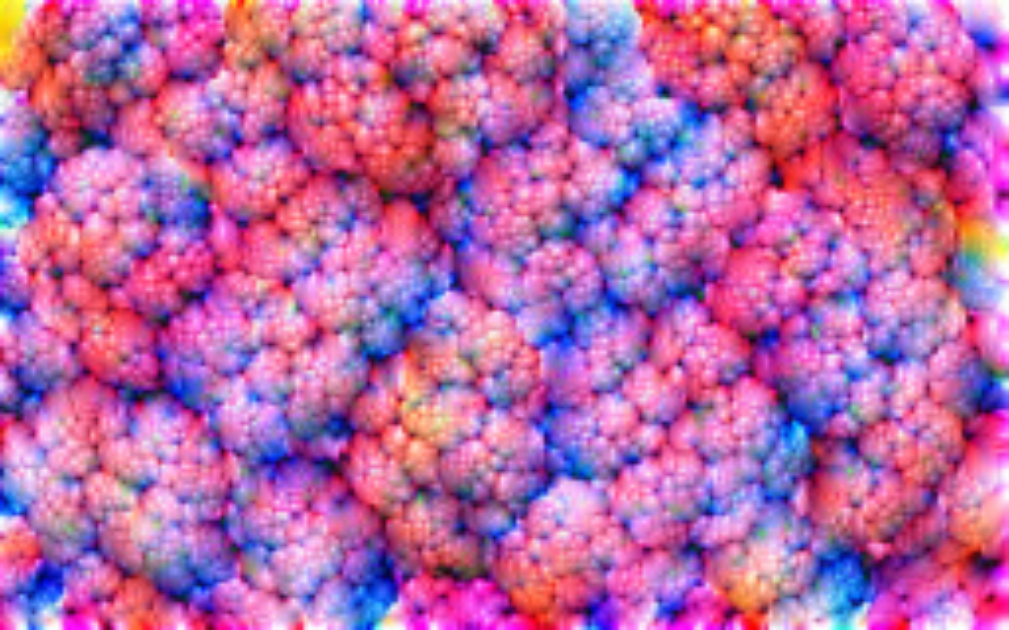

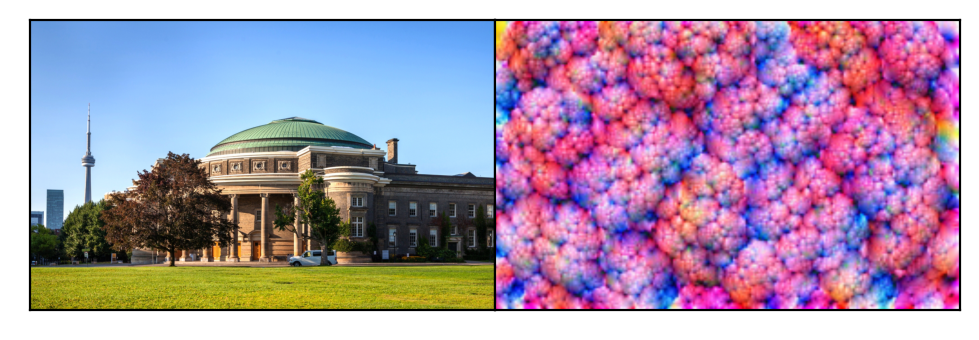

In [ ]:
url = 'https://static.timesofisrael.com/blogs/uploads/2019/11/Optimized-ConvocationHall-uoft-cntower.jpg'

input_img = utils.get_image(url)
input_img = input_img[np.newaxis, ...]


# update `input_img` to maximize activations of your selected layers. 
# assign output to `dream_img` variable
# Deeper layers will result in cooler outputs!

np.shape(input_img)
x = jax.image.resize(input_img, [1,3,160,256], "bilinear", antialias=True)
for la in range(len(layer_names)):
    if layer_names[la][0] == 'c':
        print('layer index for this iteration:', la, la+1)
        if la > 28:
            x = FeatureVis(model_2, [la, la+1], [2, 2]).vis_octave(x, steps_per_oct=100, step_size=1)
        else:
            x = FeatureVis(model_2, [la], [2]).vis_octave(x, steps_per_oct=100, step_size=1)
        x = jax.image.resize(x, [1,3,160,256], "bilinear", antialias=True)
        la += 1

dream_img = jax.image.resize(x, [1,3,630,1009], "bilinear", antialias=True)


fig, axs = plt.subplots(1, 2, dpi=200)
fig.subplots_adjust(wspace=0, hspace=0)
for x, ax in zip((input_img, dream_img), axs.flat):
    x = np.transpose(x[0], (1, 2, 0)).astype(np.uint8)
    ax.imshow(x)
    ax.set_xticks([])
    ax.set_yticks([])

imshow(dream_img)